In [75]:
import os
import torch
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import torchvision as tv
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    EarlyStopping,
)
from src.utils.helpers import load_config
from src.training.dataset import ImageDataModule
from src.models.classification_model import ImageClassifier

In [76]:
real_files = os.listdir("src/data/sampled/train/real")
fake_files = os.listdir("src/data/sampled/train/ai")

real_count, fake_count = len(real_files), len(fake_files)
print(f"REAL COUNT: {real_count} ({round(real_count/(fake_count+real_count) * 100, 1)}%)")
print(f"FAKE COUNT: {fake_count} ({round(fake_count/(fake_count+real_count) * 100, 1)}%)")

REAL COUNT: 16800 (50.0%)
FAKE COUNT: 16800 (50.0%)


In [77]:
torch.set_float32_matmul_precision("high")
config = load_config("src/configs/sampled_efficientnet_b0.yaml")
pl.seed_everything(config.get("seed"))

csv_logger = CSVLogger(
    save_dir=config["logging"].get("logs_dir", "logs"),
    name=config.get("experiment_name"),
)

Seed set to 7643


In [78]:
callbacks = []
data_module = ImageDataModule(config)

# Initialize model:
net = ImageClassifier(config)

# Enable learning rate monitoring hook:
if config["training"].get("lr_monitoring"):
    monitor_lr = LearningRateMonitor(logging_interval="epoch")
    callbacks.append(monitor_lr)

# Enable early stopping hook:
estop = config["training"].get("early_stopping", {})
if estop.get("enabled"):
    early_stopping = EarlyStopping(
        monitor=estop.get("monitor", "val_loss"),
        patience=estop.get("patience", 5),
        mode=estop.get("mode", "min"),
        verbose=True,
    )
    callbacks.append(early_stopping)

# Enable model checkpointing hook:
checkpoint = ModelCheckpoint(
    dirpath=config["logging"].get("checkpoint_dir", "checkpoints"),
    filename="{epoch:02d}-{val_acc:.2f}",
    save_top_k=1,
    monitor="val_acc",
    mode="max",
    save_last=True,
)
callbacks.append(checkpoint)

In [79]:
# Configure training session:
trainer = pl.Trainer(
    min_epochs=config["training"].get("min_epochs"),
    max_epochs=config["training"].get("max_epochs", -1),
    logger=csv_logger,
    enable_checkpointing=True,
    enable_progress_bar=True,
    enable_model_summary=True,
    devices="auto",
    accelerator="auto",
    log_every_n_steps=5,
    callbacks=callbacks,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [80]:
# Begin training:
trainer.fit(
    model=net,
    datamodule=data_module,
)

[NOTICE] Found 50 corrupted files in src/data/sampled/train.
[NOTICE] Found 5 corrupted files in src/data/sampled/validation.


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /teamspace/studios/this_studio/Reveal-AI/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | loss_func | CrossEntropyLoss | 0      | train
1 | backbone  | EfficientNet     | 4.0 M  | train
-------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)
338       Modules in train mode
0         Modules in eval mode


[NOTICE] Found 13 corrupted files in src/data/sampled/test.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.890


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.264 >= min_delta = 0.0. New best score: 0.626


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 0.511


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 0.431


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.400


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.383


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.365


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.359


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.351


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [81]:
def plot_metrics(filepath: str):
    metrics_df = pd.read_csv(filepath)
    train_acc = metrics_df["train_acc"].dropna(ignore_index=True)
    val_acc = metrics_df["val_acc"].dropna(ignore_index=True)
    train_loss = metrics_df["train_loss"].dropna(ignore_index=True)
    val_loss = metrics_df["val_loss"].dropna(ignore_index=True)

    # Losses:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ax1.plot(train_loss, label="Train Loss", c="skyblue")
    ax1.plot(val_loss, label="Validation Loss", c="red")
    # Labels:
    ax1.set_title("Loss Curves")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_xticks(range(0, len(train_loss)))
    ax1.grid()
    ax1.legend()
    # Accuracies:
    ax2.plot(train_acc, label="Train Accuracy", c="green")
    ax2.plot(val_acc, label="Validation Accuracy", c="purple")
    # Labels:
    ax2.set_title("Accuracy Curves")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.set_xticks(range(0, len(train_acc)))
    ax2.grid()
    ax2.legend()
    plt.tight_layout()
    plt.show()

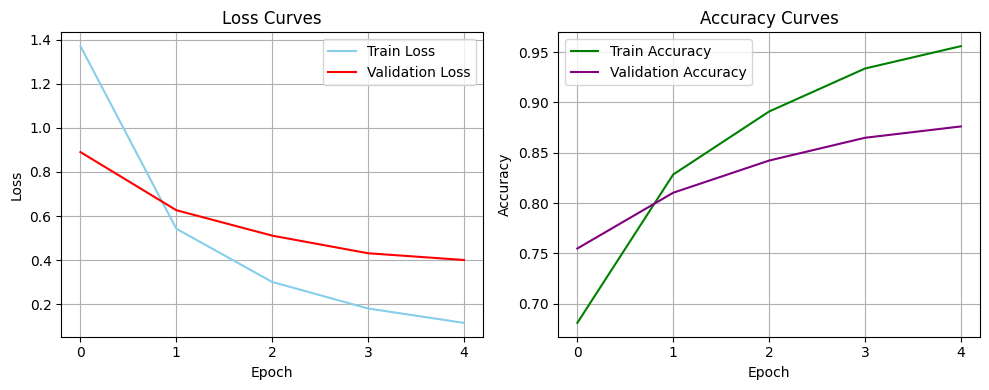

In [70]:
plot_metrics("src/logs/sampled_efficientnet_b0/version_5/metrics.csv")

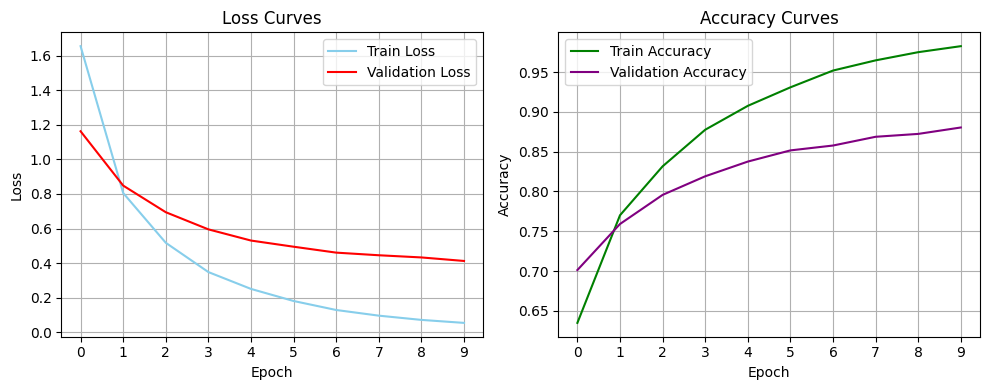

In [72]:
plot_metrics("src/logs/sampled_efficientnet_b0/version_9/metrics.csv")

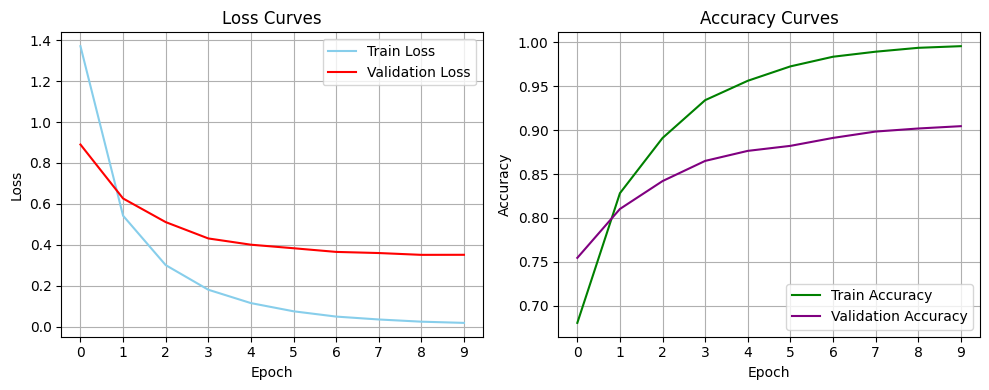

In [82]:
plot_metrics("src/logs/sampled_efficientnet_b0/version_10/metrics.csv")

In [74]:
# Test best model:
trainer.test(
    model=net,
    datamodule=data_module,
    ckpt_path="src/checkpoints/sample-enet-b0-v9.ckpt",
)

[NOTICE] Found 50 corrupted files in src/data/sampled/train.
[NOTICE] Found 5 corrupted files in src/data/sampled/validation.


Restoring states from the checkpoint path at src/checkpoints/sample-enet-b0-v9.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at src/checkpoints/sample-enet-b0-v9.ckpt


[NOTICE] Found 13 corrupted files in src/data/sampled/test.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8772784471511841     │
│         test_loss         │    0.43887051939964294    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.43887051939964294, 'test_acc': 0.8772784471511841}]

In [83]:
trainer.test(
    model=net,
    datamodule=data_module,
    ckpt_path="src/checkpoints/sample-enet-b0-v10.ckpt",
)

[NOTICE] Found 50 corrupted files in src/data/sampled/train.
[NOTICE] Found 5 corrupted files in src/data/sampled/validation.


Restoring states from the checkpoint path at src/checkpoints/sample-enet-b0-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at src/checkpoints/sample-enet-b0-v10.ckpt


[NOTICE] Found 13 corrupted files in src/data/sampled/test.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9026018977165222     │
│         test_loss         │    0.36817869544029236    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.36817869544029236, 'test_acc': 0.9026018977165222}]